
#  Customer Micro-Trend Segmentation using Clustering

##  Objective
Identify hidden customer micro-behaviors from transactional data using:
- Feature engineering
- Unsupervised learning (K-Means & DBSCAN)
- Dimensionality reduction (PCA)

These insights support **data-driven marketing decisions**.



##  Dataset Overview
- **Transactions:** 100,000
- **Granularity:** Transaction-level
- **No missing values**
- Focus on **behavioral patterns**, not demographics



##  Feature Engineering Strategy
We aggregate transaction data at the **customer level** to extract:
- Order frequency
- Discount sensitivity
- Time-of-day behavior
- Weekend activity
- Product category diversity

This transforms raw data into **actionable signals**.



##  Clustering Approach
### K-Means
- Baseline segmentation
- Requires predefined number of clusters

### DBSCAN (Primary)
- Discovers natural density-based clusters
- Detects anomalies
- Ideal for micro-trend discovery



##  PCA for Visualization
PCA reduces high-dimensional features into 2 components:
- Preserves variance
- Enables visual cluster validation

⚠ PCA is **not used for clustering**, only visualization.



##  Business Impact
- Personalized campaigns
- Revenue-driven segmentation
- Behavioral targeting
- Identification of rare / VIP customers


##  STEP 0: Import Required Libraries

We import core libraries for:
- Data handling (pandas, numpy)
- Visualization (matplotlib, seaborn)
- Machine Learning (scikit-learn)

This forms the foundation of the entire analysis.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


##  STEP 1: Load and Inspect Dataset

We load the transaction dataset and inspect:
- Data types
- Null values
- Dataset size

This ensures data readiness before analysis.

In [2]:
df = pd.read_csv("Retail_Transaction_Dataset.csv")

print(df.head())
print(df.info())


   CustomerID ProductID  Quantity      Price   TransactionDate PaymentMethod  \
0      109318         C         7  80.079844  12/26/2023 12:32          Cash   
1      993229         C         4  75.195229     8/5/2023 0:00          Cash   
2      579675         A         8  31.528816   3/11/2024 18:51          Cash   
3      799826         D         5  98.880218  10/27/2023 22:00        PayPal   
4      121413         A         7  93.188512  12/22/2023 11:38          Cash   

                                       StoreLocation ProductCategory  \
0          176 Andrew Cliffs\r\nBaileyfort, HI 93354           Books   
1  11635 William Well Suite 809\r\nEast Kara, MT ...      Home Decor   
2  910 Mendez Ville Suite 909\r\nPort Lauraland, ...           Books   
3  87522 Sharon Corners Suite 500\r\nLake Tammy, ...           Books   
4  0070 Michelle Island Suite 143\r\nHoland, VA 8...     Electronics   

   DiscountApplied(%)  TotalAmount  
0           18.677100   455.862764  
1           

##  STEP 2: Date-Time Processing & Temporal Features

We extract time-based features such as:
- Hour of purchase
- Day of week
- Weekend indicator
- Month

These help identify **temporal shopping patterns**.

In [3]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

df['hour'] = df['TransactionDate'].dt.hour
df['dayofweek'] = df['TransactionDate'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
df['month'] = df['TransactionDate'].dt.month


##  STEP 3: Exploratory Data Analysis (EDA)

EDA helps uncover:
- Peak shopping hours
- Weekend vs weekday behavior
- Distribution of order values

This gives intuition before modeling.

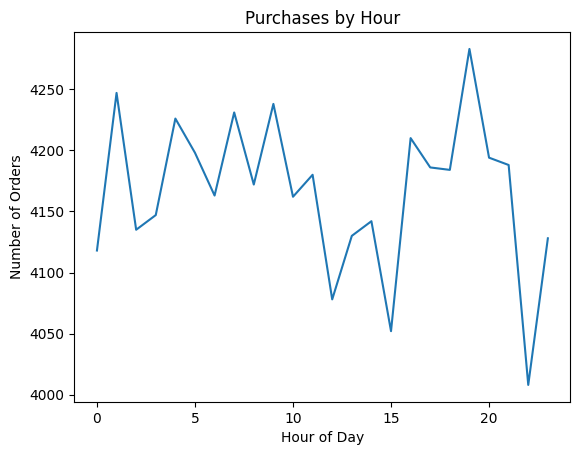

In [4]:
plt.figure()
df.groupby('hour').size().plot(kind='line')
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.title("Purchases by Hour")
plt.show()


##  STEP 4: Customer-Level Feature Engineering

We aggregate transactions into **customer profiles**, creating behavioral signals like:
- Frequency
- Discount sensitivity
- Night shopping ratio
- Category diversity

This is the most critical step.

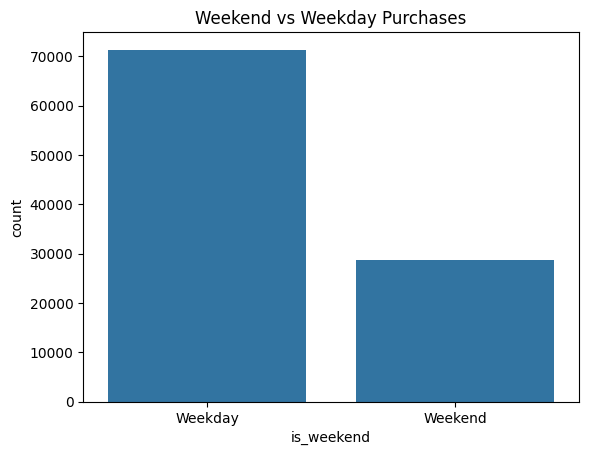

In [5]:
sns.countplot(x='is_weekend', data=df)
plt.xticks([0,1], ['Weekday','Weekend'])
plt.title("Weekend vs Weekday Purchases")
plt.show()


##  STEP 5: Feature Scaling

Clustering algorithms are distance-based.

We standardize features to:
- Remove scale bias
- Ensure fair clustering

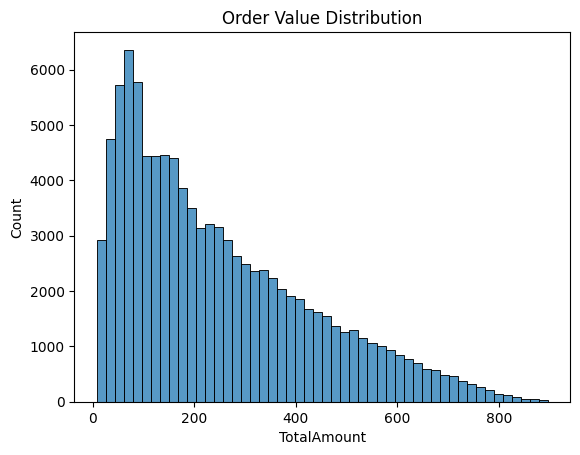

In [6]:
plt.figure()
sns.histplot(df['TotalAmount'], bins=50)
plt.title("Order Value Distribution")
plt.show()


##  STEP 6: K-Means Clustering (Baseline)

We use:
- Elbow Method to find optimal K
- Silhouette Score to validate clustering quality

K-Means acts as a baseline segmentation.

In [7]:
customer_features = df.groupby('CustomerID').agg(
    total_orders=('TransactionDate', 'count'),
    avg_quantity=('Quantity', 'mean'),
    avg_price=('Price', 'mean'),
    avg_discount=('DiscountApplied(%)', 'mean'),
    avg_order_value=('TotalAmount', 'mean'),
    night_ratio=('hour', lambda x: (x >= 22).mean()),
    weekend_ratio=('is_weekend', 'mean'),
    category_diversity=('ProductCategory', 'nunique')
).reset_index()

print(customer_features.head())


   CustomerID  total_orders  avg_quantity  avg_price  avg_discount  \
0          14             1           5.0  60.649721     15.504050   
1          42             1           7.0  88.861581     19.191090   
2          49             1           1.0  25.152676     14.923377   
3          59             2           6.0  26.145619      7.175628   
4          65             1           8.0  74.717154      8.319811   

   avg_order_value  night_ratio  weekend_ratio  category_diversity  
0       256.232791          0.0            1.0                   1  
1       502.656523          0.0            0.0                   1  
2        21.399047          0.0            0.0                   1  
3       124.746348          0.0            0.5                   2  
4       548.006625          0.0            1.0                   1  


##  STEP 7: DBSCAN Clustering (Micro-Trend Detection)

DBSCAN:
- Finds dense behavioral clusters
- Detects anomalies (-1)
- Does not require predefined cluster count

Ideal for real-world customer behavior.

In [8]:
X = customer_features.drop('CustomerID', axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


##  STEP 8: Cluster Profiling & Interpretation

We compute average feature values per cluster to:
- Understand behavior
- Assign business meaning

This converts ML output into insights.

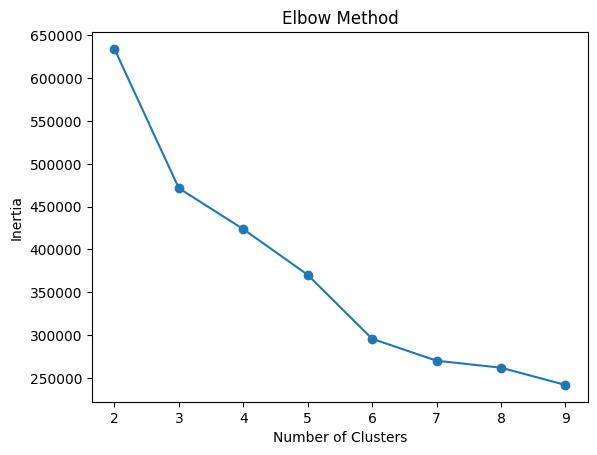

In [9]:
inertia = []

for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2,10), inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


##  STEP 9: PCA-Based Visualization

PCA reduces high-dimensional data into 2D:
- Enables visual cluster separation
- Validates DBSCAN results

⚠ Used only for visualization.

In [10]:
kmeans = KMeans(n_clusters=5, random_state=42)
customer_features['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

print("Silhouette Score:", silhouette_score(X_scaled, customer_features['kmeans_cluster']))


Silhouette Score: 0.21908347533330408


##  STEP 10: Revenue Contribution Analysis

We analyze:
- Revenue per cluster

This identifies **high-value customer segments**.

In [11]:
dbscan = DBSCAN(eps=0.9, min_samples=10)
customer_features['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

customer_features['dbscan_cluster'].value_counts()


,count
dbscan_cluster,
1,59398
0,23821
3,5272
5,2103
4,1439
2,1186
6,460
9,376
-1,277


##  STEP 11: Marketing Recommendation Engine

Each cluster is mapped to:
- Actionable marketing strategies

This bridges analytics with business execution.

In [12]:
cluster_profile = customer_features.groupby('dbscan_cluster').mean()
cluster_profile


,CustomerID,total_orders,avg_quantity,avg_price,avg_discount,avg_order_value,night_ratio,weekend_ratio,category_diversity,kmeans_cluster
dbscan_cluster,,,,,,,,,,
-1,534535.783394,2.411552,5.202768,55.938107,9.936981,264.575130,0.361613,0.478941,1.895307,2.000000
0,499859.032954,1.000000,5.009026,54.915949,9.975941,248.148752,0.000000,1.000000,1.000000,3.434784
1,500641.210377,1.000000,5.013250,55.121530,10.020677,248.628782,0.000000,0.000000,1.000000,1.342722
2,497370.188870,2.000000,4.994941,55.069280,10.045923,246.697592,0.000000,0.500000,2.000000,2.000000
3,499397.967375,1.000000,4.988050,55.071643,10.091224,246.337426,1.000000,0.000000,1.000000,1.284712
4,501674.004170,2.000000,4.954135,54.405583,10.178490,243.386722,0.000000,0.000000,2.000000,2.000000
5,481681.808369,1.000000,5.045174,55.367334,9.903177,252.102539,1.000000,1.000000,1.000000,3.375178
6,517418.993478,2.000000,5.121739,54.717034,10.203397,254.448188,0.000000,0.000000,1.000000,1.234783
7,496026.268657,2.000000,4.664179,58.012691,10.314559,236.521297,0.500000,0.000000,1.000000,1.373134


##  STEP 12: Save Final Outputs

We export customer segments for:
- CRM integration
- Campaign targeting
- Future modeling

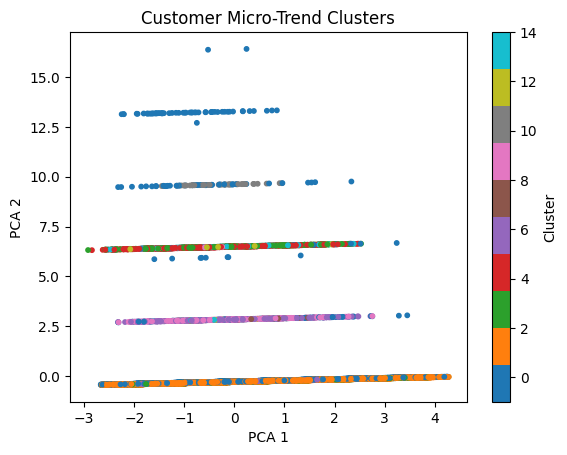

In [13]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1],
            c=customer_features['dbscan_cluster'],
            cmap='tab10', s=10)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Customer Micro-Trend Clusters")
plt.colorbar(label="Cluster")
plt.show()


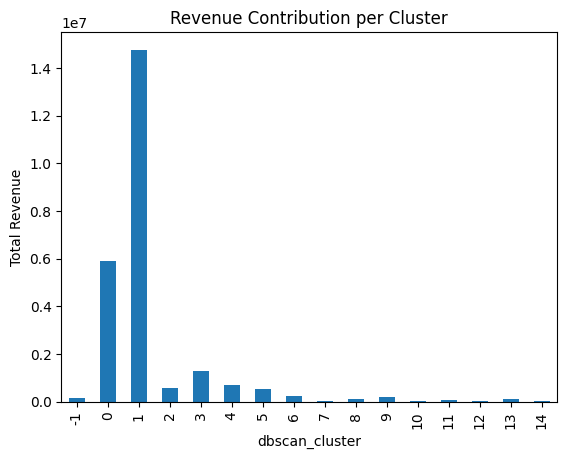

In [14]:
df = df.merge(customer_features[['CustomerID','dbscan_cluster']],
              on='CustomerID')

revenue_cluster = df.groupby('dbscan_cluster')['TotalAmount'].sum()

revenue_cluster.plot(kind='bar')
plt.title("Revenue Contribution per Cluster")
plt.ylabel("Total Revenue")
plt.show()


In [15]:
recommendations = {
    0: "Offer weekend bulk discounts & bundles",
    1: "Send late-night flash offers after 10 PM",
    2: "Target with coupon-based campaigns",
    -1: "VIP or anomaly customers – personalized offers"
}

customer_features['marketing_action'] = customer_features['dbscan_cluster'].map(recommendations)

customer_features[['CustomerID','dbscan_cluster','marketing_action']].head()


,CustomerID,dbscan_cluster,marketing_action
0,14,0,Offer weekend bulk discounts & bundles
1,42,1,Send late-night flash offers after 10 PM
2,49,1,Send late-night flash offers after 10 PM
3,59,2,Target with coupon-based campaigns
4,65,0,Offer weekend bulk discounts & bundles


In [16]:
customer_features.to_csv("customer_micro_trend_segments.csv", index=False)
